# Crop yield prediction 

Predicting crop yield can be beneficial to multiple involved parties - farmers, insurers, governments, etc.  
I go into the reasons why I've chosen this topic in the [README](README.md) of this project.

Browse specific sections in this notebook:
- [Data preparation](#data-preparation)

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, normalized_mutual_info_score


## Data preparation
- Using [crop yield prediction](https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset) dataset from Kaggle
- Dataset contains 5 different files (located in the **data** folder)
- According to the information provided in the dataset link, 
  - [yield_df.csv](./data/yield_df.csv) _is the final dataset processed by cleaning & merging of pesticides, yield, rainfall & avg. temperature._
- Explore the data in the `yield_df.csv` file

In [11]:
df = pd.read_csv("data/yield_df.csv")
print(f"\nDataset contains a total of {df.shape[0]} entries.\n")
df.head()


Dataset contains a total of 28242 entries.



,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [12]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("/","_")
df.head()

,unnamed:_0,area,item,year,hg_ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [13]:
# Standardize values for the categorical variables
categorical = ["area", "item"]

for col in categorical:
    df[col] = df[col].str.lower().str.replace(" ", "_").str.replace(",", "")

df.head()

,unnamed:_0,area,item,year,hg_ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,albania,maize,1990,36613,1485.0,121.0,16.37
1,1,albania,potatoes,1990,66667,1485.0,121.0,16.37
2,2,albania,rice_paddy,1990,23333,1485.0,121.0,16.37
3,3,albania,sorghum,1990,12500,1485.0,121.0,16.37
4,4,albania,soybeans,1990,7000,1485.0,121.0,16.37


In [14]:
# Remove `Unnamed: 0` column as it seems to not serve any purpose, duplicates index value.
df = df.drop("unnamed:_0", axis=1)

In [15]:
# Columns seem to have correct data types
df.dtypes

area                              object
item                              object
year                               int64
hg_ha_yield                        int64
average_rain_fall_mm_per_year    float64
pesticides_tonnes                float64
avg_temp                         float64
dtype: object

After reviewing the data, we determing that `hg/ha_yield` is going to be our target variable.  
That's HectoGram per Hectare

## Exploratory data analysis

In [16]:
df.item.unique()

array(['maize', 'potatoes', 'rice_paddy', 'sorghum', 'soybeans', 'wheat',
       'cassava', 'sweet_potatoes', 'plantains_and_others', 'yams'],
      dtype=object)

In [17]:
df.area.unique()

array(['albania', 'algeria', 'angola', 'argentina', 'armenia',
       'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain',
       'bangladesh', 'belarus', 'belgium', 'botswana', 'brazil',
       'bulgaria', 'burkina_faso', 'burundi', 'cameroon', 'canada',
       'central_african_republic', 'chile', 'colombia', 'croatia',
       'denmark', 'dominican_republic', 'ecuador', 'egypt', 'el_salvador',
       'eritrea', 'estonia', 'finland', 'france', 'germany', 'ghana',
       'greece', 'guatemala', 'guinea', 'guyana', 'haiti', 'honduras',
       'hungary', 'india', 'indonesia', 'iraq', 'ireland', 'italy',
       'jamaica', 'japan', 'kazakhstan', 'kenya', 'latvia', 'lebanon',
       'lesotho', 'libya', 'lithuania', 'madagascar', 'malawi',
       'malaysia', 'mali', 'mauritania', 'mauritius', 'mexico',
       'montenegro', 'morocco', 'mozambique', 'namibia', 'nepal',
       'netherlands', 'new_zealand', 'nicaragua', 'niger', 'norway',
       'pakistan', 'papua_new_guinea', 'peru', 'pola

In [18]:
df.describe()

,year,hg_ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


Text(0.5, 1.0, 'Distribution of yield')

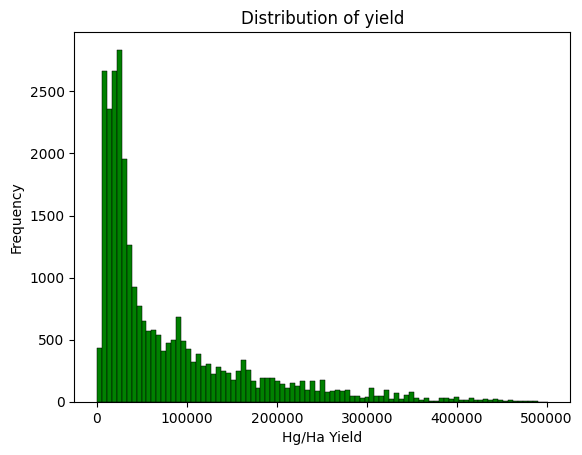

In [19]:
sns.histplot(df.hg_ha_yield, color="green", alpha=1)
plt.ylabel("Frequency")
plt.xlabel("Hg/Ha Yield")
plt.title("Distribution of yield")

Text(0.5, 1.0, 'Distribution of yield')

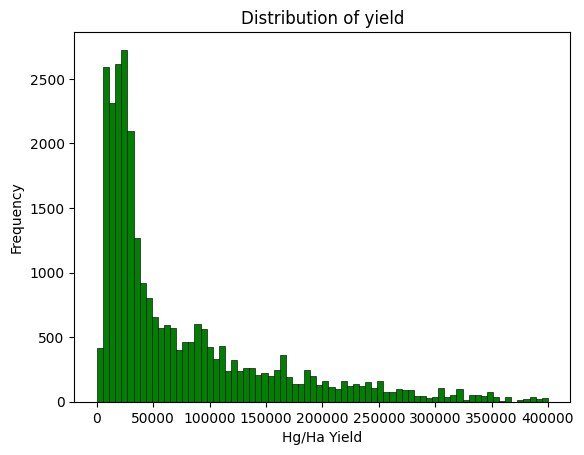

In [20]:
sns.histplot(df.hg_ha_yield[df.hg_ha_yield < 400000], color="green", alpha=1)
plt.ylabel("Frequency")
plt.xlabel("Hg/Ha Yield")
plt.title("Distribution of yield")

Text(0.5, 1.0, 'Distribution of yield after log transformation')

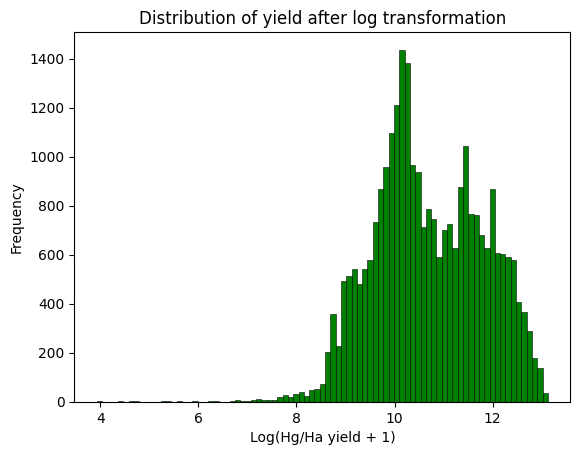

In [21]:
log_price = np.log1p(df.hg_ha_yield)

sns.histplot(log_price, color="green", alpha=1)
plt.ylabel("Frequency")
plt.xlabel("Log(Hg/Ha yield + 1)")
plt.title("Distribution of yield after log transformation")

In [22]:
df.isnull().sum()

area                             0
item                             0
year                             0
hg_ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

# Feature importance

In [23]:
# wrapper because apply only allows for one argument

categorical = ["area", "item"]

def mutual_info_churn_score(series):
    return normalized_mutual_info_score(series, df.hg_ha_yield)

# check mutual info score for each categorical variable against hg_ha_yield
mi = df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)
# Both Area and Item have strong correlation with Hg/Ha Yield

area    0.597332
item    0.381576
dtype: float64

In [24]:
numerical = ["year", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]
df[numerical].corrwith(df.hg_ha_yield).abs().nlargest()

avg_temp                         0.114777
year                             0.091630
pesticides_tonnes                0.064085
average_rain_fall_mm_per_year    0.000962
dtype: float64

In [25]:
random_seed = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_seed)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.hg_ha_yield.values)
y_val = np.log1p(df_val.hg_ha_yield.values)
y_test = np.log1p(df_test.hg_ha_yield.values)

del df_train["hg_ha_yield"]
del df_val["hg_ha_yield"]
del df_test["hg_ha_yield"]

In [26]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Evaluate results from:
- Linear regression
- Ridge, Lasso
- DecisionTreeRegressor
- RandomForestRegressor
- GradientBoostingRegressor

In [27]:
model_names = []
results = []
for _class in [LinearRegression, Ridge, Lasso, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor]:
    print(_class.__name__)
    model_names.append(_class.__name__)
    kwargs = {}
    if _class in [DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor]:
        kwargs["max_depth"] = 5
    if _class in [RandomForestRegressor, GradientBoostingRegressor]:
        kwargs["n_estimators"] = 200
        kwargs["min_samples_leaf"] = 3

    # Initiate model
    model = _class(**kwargs)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Measure predictive performance 
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    results.append((y_pred, rmse))

LinearRegression
Ridge
Lasso
DecisionTreeRegressor
RandomForestRegressor
GradientBoostingRegressor


In [28]:
df_results = pd.DataFrame(results, columns=["PRED", "RMSE"], index=model_names)
df_results

,PRED,RMSE
LinearRegression,"[12.153766927309334, 12.36700292956084, 10.240...",0.455921
Ridge,"[12.16133692492642, 12.363100565757644, 10.226...",0.455794
Lasso,"[10.72722842634275, 10.587298797985207, 10.598...",1.101233
DecisionTreeRegressor,"[12.041009013649152, 12.191796942728729, 10.02...",0.653725
RandomForestRegressor,"[12.050318665051067, 12.200863550163476, 10.09...",0.632790
GradientBoostingRegressor,"[12.08287686514911, 12.255947384790344, 10.301...",0.272350


Histogram of Y_pred(red) VS Y_true(blue) for LinearRegression


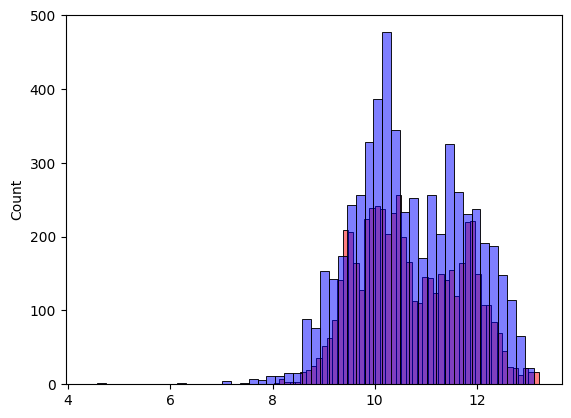

Histogram of Y_pred(red) VS Y_true(blue) for Ridge


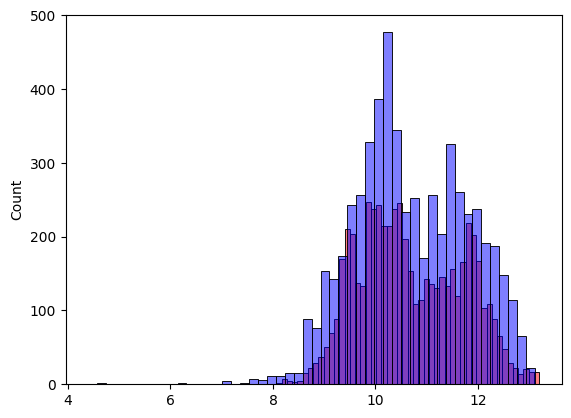

Histogram of Y_pred(red) VS Y_true(blue) for Lasso


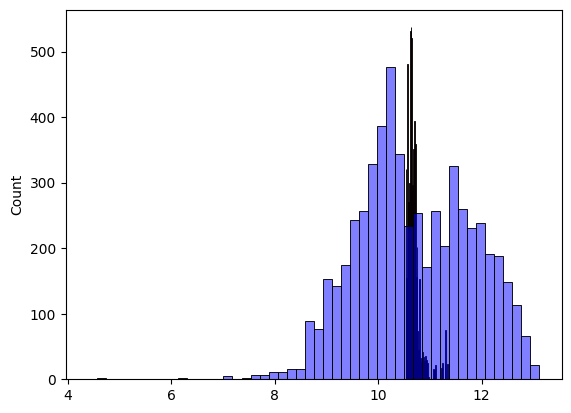

Histogram of Y_pred(red) VS Y_true(blue) for DecisionTreeRegressor


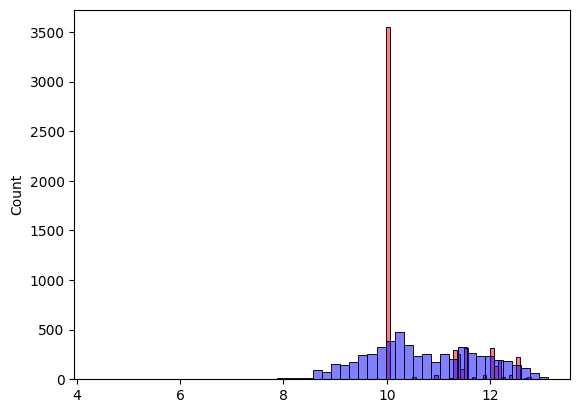

Histogram of Y_pred(red) VS Y_true(blue) for RandomForestRegressor


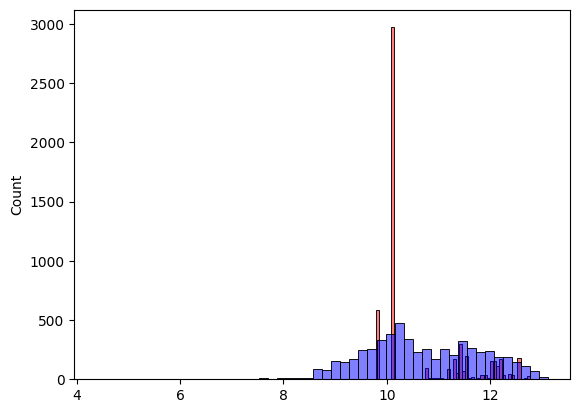

Histogram of Y_pred(red) VS Y_true(blue) for GradientBoostingRegressor


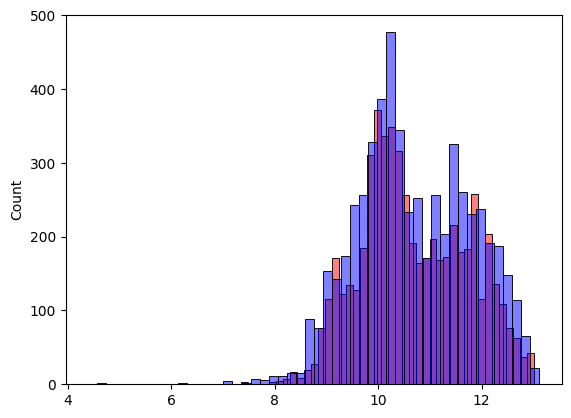

In [29]:
for model_name in model_names:
    pred = df_results.loc[model_name]["PRED"]
    print(f"Histogram of Y_pred(red) VS Y_true(blue) for {model_name}")
    sns.histplot(pred, color="red", alpha=0.5, bins=50)
    sns.histplot(y_val, color="blue", alpha=0.5, bins=50)
    plt.show()


#### GradientBoostingRegressor - chosen model
Best RMSE without parameter tuning - 0.272639

### Parameter tuning
I will use GridSearchCV.  
It is a hyperparameter tuning technique that exhaustively searches through a specified hyperparameter grid and  
finds the best combination of hyperparameters.

In [30]:
# This took 20 minutes to complete

param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [1, 3, 4, 6, 10],
    'min_samples_leaf': [1, 3, 5, 10, 50],
}
# model_two = GradientBoostingRegressor()

# grid_search_two = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
# grid_search_two.fit(X_train, y_train)
# This took 20 minutes to complete

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=20; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=20; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=20; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=20; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=1, min_samples_leaf=1, n_estimators=20; total time=   0.9s
[CV] END learning_ra

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_depth=5,
                                                 min_samples_leaf=3,
                                                 n_estimators=200),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [1, 3, 4, 6, 10],
                         'min_samples_leaf': [1, 3, 5, 10, 50],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='neg_root_mean_squared_error', verbose=2)

Results from Grid Search 

The best estimator across ALL searched params:
GradientBoostingRegressor(learning_rate=0.3, max_depth=10, n_estimators=50)

The best parameters across ALL searched params:
{'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}

The best RMSE across all searched params is 0.18673196751275872, which is significant improvement from 0.272639 (without parameter tuning)

In [31]:
best_params = {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
model = GradientBoostingRegressor(**best_params, random_state=random_seed)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.3, max_depth=10, n_estimators=50,
                          random_state=1)

In [32]:
y_pred = model.predict(X_val)
# Measure predictive performance 
mse = mean_squared_error(y_val, y_pred)
model_rmse = np.sqrt(mse)
print(model_rmse)
# Training best model with best params gives RMSE~0.2


0.19600859746081398


## Final model

Get the final model with best params and full training data

In [33]:
df_full_train.reset_index(drop=True)
y_full_train = np.log1p(df_full_train.hg_ha_yield.values)

del df_full_train["hg_ha_yield"]

In [34]:
dicts_full_train = df_full_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient="records")
X_test = dv.transform(dicts_test)

In [35]:
best_params = {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
best_model = GradientBoostingRegressor(**best_params, random_state=random_seed)
best_model.fit(X_full_train, y_full_train)

GradientBoostingRegressor(learning_rate=0.3, max_depth=10, n_estimators=50,
                          random_state=1)

In [36]:
y_pred = model.predict(X_test)
# Measure predictive performance 
mse = mean_squared_error(y_test, y_pred)
best_model_rmse = np.sqrt(mse)
print(best_model_rmse)
# Training best model with best params gives RMSE~0.19


0.18520501958552765


<Axes: ylabel='Count'>

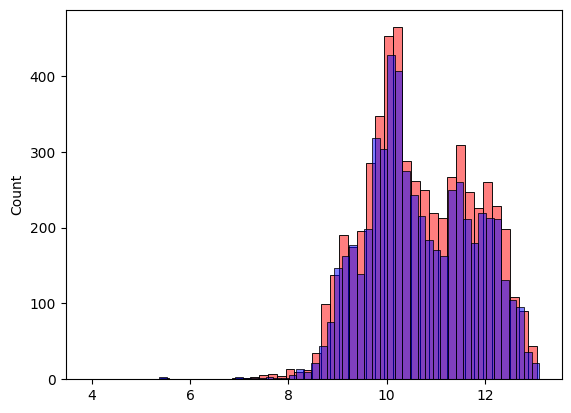

In [37]:
y_pred = model.predict(X_test)
sns.histplot(y_test, color="red", alpha=0.5, bins=50)
sns.histplot(y_pred, color="blue", alpha=0.5, bins=50)


### Testing model performance for individual cases

In [38]:
import random

idx = random.randint(1, len(df_test))
random_yield_data = df_test.iloc[idx].to_dict()
print(random_yield_data)
actual_yield = np.expm1(y_test[idx])

X_random_yield = dv.transform([random_yield_data])
predicted_log1p_yield = best_model.predict(X_random_yield)
predicted_yield = np.expm1(predicted_log1p_yield)[0]

print("Actual yield", actual_yield)
print("Predicted yield", predicted_yield)
print("Difference in between predicted and actual yield, Absolute numbers", abs(actual_yield - predicted_yield))
print("Difference in between predicted and actual yield, as Percentage", abs(actual_yield - predicted_yield)/ actual_yield * 100)


{'area': 'rwanda', 'item': 'sweet_potatoes', 'year': 1998, 'average_rain_fall_mm_per_year': 1212.0, 'pesticides_tonnes': 157.0, 'avg_temp': 19.79}
Actual yield 50463.00000000003
Predicted yield 49874.4809502928
Difference in between predicted and actual yield, Absolute numbers 588.5190497072326
Difference in between predicted and actual yield, as Percentage 1.166238728785907


# Saving the model

In [39]:
import pickle

output_file_name = "model.bin"
# Open file and instruct that we will "wb" = Write Bytes (not text)
with open(output_file_name, "wb") as f_out:
    # Need also DictVectorizer, otherwise won't be able to translate a customer to feature matrix
    pickle.dump((dv, best_model), f_out)

# Load the model

In [40]:
import pickle
model_file_name = "model.bin"
# Open model_file and instruct that we will "rb" = Read Bytes
with open(model_file_name, "rb") as f_in:
    # Need also DictVectorizer, otherwise won't be able to translate a customer to feature matrix
    dv, model = pickle.load(f_in)